![imagem](http://lapix.ufsc.br/wp-content/uploads/2022/09/NB-banner-PT.jpg)
# 15.2.1.Notebook para Segmentação por Instância - Detectron2 (MaskRCNN)
#### Novembro de 2024

### Autores:
<b>Autores</b>:

*   Aldo von Wangenheim (aldo.vw@ufsc.br) [Review, Maintainer]
*   Rodrigo de Paula e Silva Ribeiro (ribeiro.rodrigo@posgrad.ufsc.br)  [Review, Code, Dataset, Maintainer]


CERTIFIQUE-SE DE TER INCIADO O AMBIENTE EM MODO <b>GPU</b> ANTES DE REALIZAR OS PROCEDIMENTOS.<br>
NA TROCA DO AMBIENTE ELE <b><u>PERDE</u></b> TODOS OS DADOS BAIXADOS.

AO RE-EXECUTAR OS PROCEDIMENTOS (ex. diminuir o batch size), <br>REINICIE O AMBIENTE PARA LIBERAR O CACHE DO PYTORCH (reiniciar não perde os dados da sessão).<br>(alt+m ou pelo menu "Ambiente de Execução")

EXECUTE UTILIZANDO RUN ALL ou CTRL+F9


<a href="https://colab.research.google.com/github.com/awangenh/vision/blob/master/jupyter/15.2.1.Segmenta%C3%A7%C3%A3o%20por%20Inst%C3%A2ncia%20-%20Detectron%20V2.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-greeng" alt="Python Version" title="Python Version"></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvidia-smi
!nvcc --version

# Test if your notebook is running on Google Colab
# You'll use this when choosing between doing interaction via ipywidgets or not.
try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
else:
    BASE_PATH = "/lapix" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix

os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

# Suprimir Avisos Gerais na saida do notebook
Suprimir apenas "avisos", erros irá mostrar a causar e efetuará a parada do notebook normalmente.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Configurações dos Loggers Externos

## Descrição dos Loggers e suas funções.
Este notebook oferece logging de informações do treino para ambiente externo.
Mais especificamente para: [WandB](https://wandb.ai/) e [Neptune](https://neptune.ai/).<br>
WandB e Neptune são gerenciadores de projetos de machine learning que possibilitam a comparação analítica de maneira facilitada entre vários treinos de um mesmo modelo comparando diferentes parâmetros.<br>
Há ainda opções avançadas para salvar modelos e datasets na nuvem (necessita assinatura paga) de forma a facilitar a portabilidade entre diferentes frameworks de ML.<br>
Para utilizá-los, é necessário acessar o site (clikar nos links acima) e efetuar um cadastro gratuito para obter uma chave de api.<br>
Após, alterar no bloco abaixo, os locais indicados com as chaves e mudar a variável de ativação para "True".<br>
Caso não deseje utilizar loggers externos, manter as variáveis de ativação em "False".<br>
O [Detectron2](https://github.com/facebookresearch/detectron2), por padrão, ao final do treino, irá gerar um arquivo 'metrics.json', onde é possível visualizar e analisar os dados de treino e eventualmente montar seu próprio comparador analítico entre treinos.

In [ ]:
"""
# EXTERNAL LOGGERS
"""
WANDB_LOGGER = False # Ativa o log das métricas básicas no wandb.ai, requer mais configurações abaixo.
NPT_LOGGER = False # Ativa o log das métricas básicas no nepture.ai, requer mais configurações abaixo.

"""
# WANDB CONFIG
"""
WANDB_API_KEY = "***" # wandb.ai api-key, trocar *** por sua api key
WANDB_PROJECT_NAME = "Cones-Teste" # Nome do projeto onde será logado as métricas (pode ser projeto já existente), caso deixe vazio será gerado um nome aleatório no wandb.ai
WANDB_ENTITY = "wndb_username" # A entidade que está enviando os dados.
WANDB_RUN_ID = "" # Em caso de resumo é necessário passar o RUN-ID para continuar logando as métricas na mesma run.

"""
# NEPTUNE CONFIG
"""
NPT_PROJECT_NAME = "---" # O nome do projeto para o qual será enviado os dados (definido no neptune.ai).
NPT_TOKEN = "***" # A api token do neptune.ai, trocar *** pela sua api key fornecida no neptune.ai
NPT_RUN_ID = "" # Em caso de resumo é necessário passar o RUN-ID para continuar logando na mesma run.


In [ ]:
INSTALL_LIBS = False # Setar para True para instalar localmente também (Não é necessário se estiver rodando nos conteiners Lapix)

if _ON_COLAB:
    INSTALL_LIBS = True

if INSTALL_LIBS:
    !pip install wandb -q
    !pip install neptune-client -q

     |████████████████████████████████| 1.9 MB 3.9 MB/s 
     |████████████████████████████████| 182 kB 24.3 MB/s 
     |████████████████████████████████| 168 kB 12.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 166 kB 10.4 MB/s 
     |████████████████████████████████| 166 kB 50.0 MB/s 
     |████████████████████████████████| 162 kB 14.0 MB/s 
     |████████████████████████████████| 162 kB 9.8 MB/s 
     |████████████████████████████████| 158 kB 6.5 MB/s 
     |████████████████████████████████| 157 kB 22.0 MB/s 
     |████████████████████████████████| 157 kB 22.9 MB/s 
     |████████████████████████████████| 157 kB 27.4 MB/s 
     |████████████████████████████████| 157 kB 22.5 MB/s 
     |████████████████████████████████| 157 kB 25.3 MB/s 
     |████████████████████████████████| 157 kB 24.5 MB/s 
     |████████████████████████████████| 157 kB 21.4 MB/s 
     |████████████████████████████████| 156 kB 24.6 MB/s 
     |█████████████

# Segmentação por Instância x Segmentação Semântica (diferenças)
Ambas as segmentações classificam a imagem a nível de pixel.

A principal diferença entre elas é no modo como a imagem e as máscaras detectadas são tratadas.

Na segmentação semântica, cada pixel na tela terá uma classificação e as máscaras de objetos encontrados são unificadas (ex: 3 carros na imagem, porém uma única máscara para os 3 carros).

![imagem](https://drive.google.com/thumbnail?id=1xTcpqOMJaXc3QGUj2y7U5t-abSYihF7Y&sz=w400)




Na segmentação por instância, somente as máscaras de objetos reconhecidos serão classificadas e extraidas (qualquer objeto na tela que não esteja no conjunto de dados é automaticamente descartado), e cada objeto terá uma máscara individual, permitindo detectar várias instâncias de um mesmo objeto.

![imagem](https://drive.google.com/thumbnail?id=1qrm8HqWJHl-cDj7Jhqk37Ekk7aG_lLuo&sz=w400)

# Simple Street Instance Test Dataset
Este dataset é derivado do conjunto aberto "street": https://universe.roboflow.com/hmc-nbo1u/street-has4r
Foi realizada uma limpeza, adequação de classes, verificação e adição de novas anotações.

Este dataset é para fins didáticos de funcionamento de segmentação por instância.

Classes:
* car
* bus
* truck
* traffic light
* motorcycle
* person

Amostra de anotações:<br>
![](https://drive.google.com/thumbnail?id=1B1z6p6FmU7KODn8hThMsGR-UrgohvfpN&sz=w400)
![](https://drive.google.com/thumbnail?id=1syPez_Dgg1SJkcU5yjoroUXNH6EfqAhN&sz=w400)
![](https://drive.google.com/thumbnail?id=17WMc9xcLXwIWaTqiUfNeiZw3N7PlwiGs&sz=w400)
![](https://drive.google.com/thumbnail?id=1YCtFawtuVDWMugm-UvVaKNV7g3TkMZb8&sz=w400)

# 0 Definição das variáveis de controle (treino, resumo, batchsize, epoch, lr)



<center>Diferenças das políticas de decaimento da Learning Rate.</center><br>
LR_METHODS.COSINE: Nesta política, após o aquecimento (subida) a Learning Rate irá decair suavemente com tendência a 0.<br>
LR_METHODS.STEP: Nesta política, após o aquecimento (subida) a Learning Rate irá decair por valores fixos e nos passos fixados previamente, tende a um valor específico resultado do decaimento do último passo.
<br><br>
<center>Exemplos de curvas das políticas de decaimento da Learning Rate.
<br>(laranja escuro= curva suavizada, laranja claro= curva natural)</center><br>

LR_METHODS.COSINE:<br>
![](https://drive.google.com/thumbnail?id=1ih5TR3qpT17WZtMl-RjIH7HK39eJ_0hb&sz=w800)

LR_METHODS.STEP:<br>
![](https://drive.google.com/thumbnail?id=1p87kdvgwqcmpym9lDy_LKhsj_04ydkDM&sz=w800)

## OneCycle
É um método de convergência acelerada proposto por Leslie N. Smith em 2017.
O método varia a taxa de aprendizado e momentum da rede de forma que a taxa de aprendizado sobe até um pico e depois decresce gradualmente, por outro lado,  o momentum da rede obedece uma curvatura inversa da taxa de aprendizagem como ilustrado abaixo.<br>
![imagem](https://miro.medium.com/max/720/1*38YBWIKFwXN0YlNOVo_LOA.jpeg)

O framework fast.ai implementa uma variação deste método e é um dos métodos mais utilizado no fast.ai. Também está disponível no framework pytorch (implementação original e do fast.ai). Este notebook utiliza-se da implementação do pytorch, deixando ao usuário a liberdade de escolha entre a variação do fast.ai ou o modo original.<br>Mais detalhes podem ser encontrados nos materiais a seguir:
* https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
* A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay — https://arxiv.org/abs/1803.09820
* Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates — https://arxiv.org/abs/1708.07120

In [ ]:
from enum import Enum
#-- membros estáticos
LR_METHODS = Enum("LR_METHODS", "COSINE FIXED STEP ONECYCLE")
#--

"""
# CONFIGS GENERICAS
"""
NUM_EPOCH = 35 # Define o número de épocas para rodar ex: 100
SAVE_EPOCH = 5 # Define o intervalo de épocas para salvar, ex: de 1 em 1
BSIZE = 12 # Define o batch_size, ex: 12
LEARNING_RATE = 0.002 # Define a learnig rate base, ex: 0.01
WARMUP_ITERS = 50 # Número de iterações iniciais para aquecimento da LR. Padrão: 1000

# Define o método para learning rate adaptativa.
# Atualmente disponíveis: LR_METHODS.COSINE, LR_METHODS.FIXED, LR_METHODS.STEP e LR_METHODS.ONECYCLE (ver gráficos/info no bloco acima)
# LR_METHODS.FIXED >> mantém a learning rate fixa o tempo todo sem decaimento.
LR_METHOD = LR_METHODS.ONECYCLE

"""
# COSINE CONFIGS (LR_METHODS.COSINE)
"""
# Define o momentum base para a LR no método Cosine.
LR_MOMENTUM = 0.9


"""
# STEP CONFIGS (LR_METHODS.STEP)
"""
# Array das n% de decay em 0-1, ex: 60%, 80%, 90% = [0.6, 0.8, 0.9], primeiro decay aos 60% do conjunto treinado, segundo aos 80% e terceiro/último aos 90%.
LR_STEPS_DECAY = [0.6, 0.8]
# Define o quanto vai decair a Learning Rate atual em cada passo: LR_BASE = 0.1, decay1 = LR_BASE * STEP_RATE = 0.01, decay2 = NOVA_LR(0.01) * STEP_RATE = 0.001, etc..
LR_STEP_RATE = 0.1

"""
# ONECYCLE CONFIGS (LR_METHODS.ONECYCLE)
"""
OC_LIMIT = 0.01 # limite maximo de crescimento da learning rate
OC_MIN_MOMENTUM = 0.85 # momentum minimo
OC_MAX_MOMENTUM = 0.95 # momentum maximo
OC_THREE_PHASE = False # True para usar a versao original do Artigo. False para usar a modificação do pytorch/fast.ai (não publicado mas teoricamente melhor)


"""
# CONFIGS PARA RESUMO DE TREINO
"""
RESUMIR = False # False = novo treino, ao RESUMIR AS CONFIG ACIMA SAO IGNORADAS E CARREGADAS DO ARQUIVO DO MODELO (para evitar erros por diferença)
PASTA_RESUMO = "27-8-2022_12_32_40" # pasta onde foi salvo o treino a ser resumido

"""
# CONFIGS DE PASTA PARA SALVAMENTO 
"""
PROJECT_NAME = "Detectron2_Instance"
GDRIVE_SAVE = False # Setar True e montar o drive na proxima célula para salvar as runs no drive

<IPython.core.display.Javascript object>

# 1 Montar o google drive
Apenas para usuarios do colab

In [ ]:
# Caso queira salvar treinamento no google drive, rodar estar célular e alterar o caminho de output da rede para o caminho do drive.
from google.colab import drive
DRIVE_PATH = os.path.join(BASE_PATH, "gdrive")
drive.mount(DRIVE_PATH, force_remount=False)

Mounted at /content/gdrive


<IPython.core.display.Javascript object>

# 2 Realizar o download dos arquivos necessários.
Download e extração do dataset e demais arquivos necessários.


In [ ]:
import os
from glob import glob
# definir onde irá salvar
if GDRIVE_SAVE:
  RUNS_PATH = os.path.join(DRIVE_PATH,PROJECT_NAME)
else:
  RUNS_PATH = os.path.join(BASE_PATH,PROJECT_NAME)
os.makedirs(RUNS_PATH, exist_ok=True)

os.chdir(BASE_PATH)
# download cones dataset
!gdown 1wBtdJjlBqOD5Oqo-QUXP-Z4vn32LnuVH
os.makedirs(os.path.join(BASE_PATH, "dataset"), exist_ok=True)
!mv simple_street_segmentation.zip {BASE_PATH}/dataset/
os.chdir(os.path.join(BASE_PATH, "dataset"))
!unzip -qq -u simple_street_segmentation.zip
!rm -rf simple_street_segmentation.zip
os.chdir(BASE_PATH)
print("Download e Extração do dataset FINALIZADA!")

Downloading...
From: https://drive.google.com/uc?id=1TxbWIbi6PEaMJnEVZZ-R4TNbwSWxNLCQ
To: /content/cone_dataset.zip
100% 111M/111M [00:00<00:00, 201MB/s] 


<IPython.core.display.Javascript object>

# 3 Conversão de dados para o formato COCO.
Realiza a conversão do formato labelme para [coco](https://cocodataset.org/#home) json. Caso não precise conversão (como é o caso do cones dataset, pule esta etapa), caso precise de outra conversão, realizar neste bloco.



In [ ]:
import os
if RESUMIR:
  print("Conversão do dataset para formato COCO: Pulando etapa... (modo de resumo já possui essa conversão).")
else:
  #!python label2coco.py "{BASE_PATH}/dataset/" --output "coco_format.json" # este dataset já está vindo no formato COCO, linha mantida apenas para referência
  pass

<IPython.core.display.Javascript object>

# 4 Divisão do dataset em train, val e test.
É usual em tarefas de Machine Learning e Deep Learning, utilizar-se de 2 a 3 subconjuntos extraidos do dataset principal.<br>
Normalmente são nomeados como Train, Val e Test Split. Ou seja, divisão de treino, validação e teste.<br>
A rede é treinada com o a divisão "train", de forma que as divisões val e test são desconhecidas para a rede. Desta forma é possível verificar situações como "Overfitting", caso que ocorre quando a rede vai bem no conjunto de treino e vai mal nos conjuntos de val e test (decora os dados mas não aprende de fato).
<br>A proporção mais utilizada é a de: 70%, 15%, 15% no caso de train/val/test ou 70%/30% (train/val).
Este notebook utiliza-se de 3 conjuntos na proporção 70/15/15.
Ao final do treino é realizada uma inferência no conjunto 'val' automaticamente.

In [ ]:
import json
from sklearn.model_selection import train_test_split
def save_coco(file, images, annotations, categories):
    with open(file, 'w') as coco:
        json.dump({ 'images': images, 'annotations': annotations, 'categories': categories}, coco, indent=2, sort_keys=True)

def filter_annotations(annotations, images):
    image_ids = map(lambda i: int(i['id']), images)
    image_ids = list(image_ids)
    filtered = filter(lambda a: int(a['image_id']) in image_ids, annotations)
    return list(filtered)

if RESUMIR:
  print("Divisão train/val/test do dataset: Pulando etapa... (modo de resumo já possui estas definições)")
else:
  pass # o dataset já está dividido em train,val e test, código mantido para referência.
  """
  _train = 0.7
  _val = 0.15
  _test = 0.15

  with open('/content/dataset/coco_format.json', 'r') as infile:
    coco = json.load(infile)
    images = coco['images']
    annotations = coco['annotations']
    categories = coco['categories']
    train_set, y = train_test_split(images, train_size=_train)
    val_set, test_set = train_test_split(y, train_size= (_val/(_val + _test)))
    os.chdir("/content/")
    save_coco('train.json', train_set, filter_annotations(annotations, train_set), categories)
    save_coco('val.json', val_set, filter_annotations(annotations, val_set), categories)
    save_coco('test.json', test_set, filter_annotations(annotations, test_set), categories)
  """

<IPython.core.display.Javascript object>

# 5 Instalação do [Detectron2](https://github.com/facebookresearch/detectron2) direto do git oficial (última versão disponível).
O detectron2 é um framework construído sobre o [PyTorch](https://pytorch.org/) pelo FAIR (Facebook Artificial Inteligence Research) que possibilita um alto nível de customização e uma grande variedade de modelos prontos para uso.<br>
Para uma versão específica é necessário alterar o git alvo no código abaixo para a versão pretendida.<br>
Para mais informações sobre o [Detectron2](https://github.com/facebookresearch/detectron2), verifique sua documentação [neste link](https://detectron2.readthedocs.io/).


In [ ]:
if _ON_COLAB:
    !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
else:
    pass # Detectron2 já está instalado nos conteineres 'lapix'


# 6 Verificação da instalação e versão do Detectron2 e do PyTorch.

In [ ]:
# verificar info da maquina
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

# 7 Treinar a rede.
Ao final do treino é realizado inferência no conjunto 'val'.

In [ ]:
import torch
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.events import get_event_storage
import detectron2.utils.comm as comm
from detectron2.engine import HookBase
from detectron2.solver.build import build_lr_scheduler, build_optimizer, get_default_optimizer_params
from detectron2.solver.lr_scheduler import WarmupCosineLR, WarmupMultiStepLR, LRMultiplier, WarmupParamScheduler
from detectron2.data import DatasetMapper, build_detection_test_loader
from fvcore.common.param_scheduler import CosineParamScheduler, MultiStepParamScheduler, StepWithFixedGammaParamScheduler
from collections import defaultdict
import neptune.new as neptune
import wandb
import os

class ExternalLogger(HookBase):
    """
    Hook para enviar os dados de treino para o WandB.ai e/ou Neptune.ai
    """
    def __init__(self, period=20, npt=False, wndb=False, resume=False, maxiter = 0):
        super().__init__()
        self._period = period
        self._npt = npt
        self._wndb = wndb
        self._resume = resume
        self._last = -1
        self._params = {"batch_size": BSIZE, "epochs": NUM_EPOCH, "learning_rate": LEARNING_RATE, "scheduler": LR_METHOD.name, "iterations": maxiter}
        if self._npt:
            if self._resume:
                self._npt_run = neptune.init_run(project=NPT_PROJECT_NAME, api_token=NPT_TOKEN, with_id=NPT_RUN_ID)
            else:
                self._npt_run = neptune.init_run(project=NPT_PROJECT_NAME, api_token=NPT_TOKEN)
        if self._wndb:
            os.environ["WANDB_SILENT"] = "True"
            os.environ["WANDB_API_KEY"] = WANDB_API_KEY
            if self._resume:
                self._wnd_run = wandb.init(project=WANDB_PROJECT_NAME, entity=WANDB_ENTITY, id=WANDB_RUN_ID, resume="must")
            else:
                self._wnd_run = wandb.init(project=WANDB_PROJECT_NAME, entity=WANDB_ENTITY)
        if not self._resume:
            self._npt_run["parameters"] = self._params
            wandb.config.update(self._params)

    def after_step(self):
        if (self.trainer.iter + 1) % self._period == 0 or (self.trainer.iter == self.trainer.max_iter - 1):
            storage = get_event_storage()
            _iter = storage.iter
            self._last = _iter
            for k, (v, iter) in storage.latest_with_smoothing_hint(self._period).items():
                if self._wndb:
                    if self._resume:
                        if wandb.run.step < _iter:
                            wandb.log({f'{k.replace("/", "-")}': v}, step=_iter)
                    else:
                        wandb.log({f'{k.replace("/", "-")}': v}, step=_iter)
                if self._npt:
                    if self._resume:
                        if self._npt_run["last_iter"].fetch() < _iter:
                            self._npt_run[k.replace("/", "-")].log(v, step=_iter)
                    else:
                        self._npt_run[k.replace("/", "-")].log(v, step=_iter)
                        self._npt_run["last_iter"] = _iter

    def after_train(self):
        storage = get_event_storage()
        for k, (v, iter) in storage.latest_with_smoothing_hint(self._period).items():
            if iter <= self._last:
                continue
            if self._wndb:
                wandb.log({f'{k.replace("/", "-")}': v}, step=iter)
            if self._npt:
                self._npt_run[k.replace("/", "-")].log(v, step=iter)
        if self._wndb:
            self._wnd_run.finish()
        if self._npt:
            self._npt_run.stop()




class DeepUFSCTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "coco_val")
            os.makedirs(output_folder, exist_ok=True)
        return COCOEvaluator(dataset_name=dataset_name, use_fast_impl=False, output_dir=output_folder)

    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        name = cfg.SOLVER.LR_SCHEDULER_NAME
        if name == "WarmupMultiStepLR":
            steps = [x for x in cfg.SOLVER.STEPS if x <= cfg.SOLVER.MAX_ITER]
            if len(steps) != len(cfg.SOLVER.STEPS):
                logger = logging.getLogger(__name__)
                logger.warning("SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.")
            sched = MultiStepParamScheduler(
              values=[cfg.SOLVER.GAMMA**k for k in range(len(steps) + 1)],
              milestones=steps,
              num_updates=cfg.SOLVER.MAX_ITER,
            )
        elif name == "WarmupCosineLR":
            end_value = cfg.SOLVER.BASE_LR_END / cfg.SOLVER.BASE_LR
            assert end_value >= 0.0 and end_value <= 1.0, end_value
            sched = CosineParamScheduler(1, end_value)
        elif name == "WarmupStepWithFixedGammaLR":
            sched = StepWithFixedGammaParamScheduler(
              base_value=1.0,
              gamma=cfg.SOLVER.GAMMA,
              num_decays=cfg.SOLVER.NUM_DECAYS,
              num_updates=cfg.SOLVER.MAX_ITER,
            )
        elif name == "OneCycleLR":
            return torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=cfg.ONECYCLE.LIMIT, base_momentum=cfg.ONECYCLE.MIN_MOMENTUM, max_momentum=cfg.ONECYCLE.MAX_MOMENTUM, total_steps=cfg.SOLVER.MAX_ITER, three_phase=cfg.ONECYCLE.THREE_PHASE)
        else:
            raise ValueError("Unknown LR scheduler: {}".format(name))

        sched = WarmupParamScheduler(
          sched,
          cfg.SOLVER.WARMUP_FACTOR,
          min(cfg.SOLVER.WARMUP_ITERS / cfg.SOLVER.MAX_ITER, 1.0),
          cfg.SOLVER.WARMUP_METHOD,
          cfg.SOLVER.RESCALE_INTERVAL,
        )
        return LRMultiplier(optimizer, multiplier=sched, max_iter=cfg.SOLVER.MAX_ITER)

Para mais modelos consulte: <a href=https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md>Detectron2 Model Zoo</a>

Caso deseje trocar o modelo em uso altere as seguintes linhas:<br>
<code>cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))<br>
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")</code><br>

Para rodar em um dataset customizado, é necessário alterar o número de classes da última camada, alterando a seguinte linha:<br>
<code>cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 # numero de classes do dataset</code><br>

Para modelos utilizados puramente para segmentação semântica, adicionar a seguinte linha:<br>
<code>cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 6 # numero de classes para segmentação semantica</code><br>

<b>Para outros modelos consulte a documentação do Detectron2 para quais atributos adicionais são necessários.</b>

O Detectron2 espera dataset no formato coco com um arquivo json para cada split (train, test, val), as imagens podem estar na mesma pasta.<br>
Para adicionar um dataset customizado, procure e edite as seguintes linhas:<br>
<code>
register_coco_instances("instance_train", {}, "/content/dataset/simple_street_segmentation/train/train.json", "/content/dataset/simple_street_segmentation/train")<br>
register_coco_instances("instance_val", {}, "/content/dataset/simple_street_segmentation/valid/valid.json", "/content/dataset/simple_street_segmentation/valid")<br>
</code>

O formato para registrar um dataset com a função register_coco_instances segue abaixo:<br>
<code>register_coco_instances("nome_para_localizar", {}, "caminho para o arquivo json", "caminho para as imagens")</code><br>

Para adicioanr ao CFG, procure e altere as seguintes linhas:<br>
<code>cfg.DATASETS.TRAIN = ("instance_train",)<br>
cfg.DATASETS.TEST = ("instance_val",)</code><br>

Altere para:<br>
<code>cfg.DATASETS.TRAIN = ("nome_registrado_para_spli_train",)<br>
cfg.DATASETS.TEST = ("nome_registrado_para_spli_validation",)</code><br>

Outras opções estão comentadas no código.

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
import matplotlib.pyplot as plt
import datetime
import pytz
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow
from detectron2.config import get_cfg
from detectron2.config import CfgNode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo
from detectron2.engine import PeriodicWriter

import logging


if RESUMIR:
  print("Modo de resumo selecionado: Pulando etapa de treinamento novo")
else:
  time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
  _msg = "Iniciando treino: OK (treino iniciado em {dia}/{mes}/{ano} as {hora}:{minuto}:{segundo})".format(dia=time_now.day, mes=time_now.month, ano=time_now.year, hora=time_now.hour, minuto=time_now.minute, segundo=time_now.second)
  print(_msg)

  setup_logger()

  cfg = get_cfg()
  cfg.ONECYCLE = CfgNode({"LIMIT": 0.01, "MAX_MOMENTUM": 0.95, "MIN_MOMENTUM": 0.85, "THREE_PHASE": False})

  cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")

  ##-- Definir os caminhos dos datasets
  DatasetCatalog.clear()
  MetadataCatalog.clear()
  register_coco_instances("instance_train", {}, os.path.join(BASE_PATH, "dataset/simple_street_segmentation/train/train.json"), os.path.join(BASE_PATH, "dataset/simple_street_segmentation/train"))
  register_coco_instances("instance_val", {}, os.path.join(BASE_PATH, "dataset/simple_street_segmentation/valid/valid.json"), os.path.join(BASE_PATH, "dataset/simple_street_segmentation/valid"))
  cfg.DATASETS.TRAIN = ("instance_train",)
  cfg.DATASETS.TEST = ("instance_val",)
  ##-- END definir caminhos datasets

  ##---------CONFIGURACOES COMEÇAM DAQUI PARA BAIXO ------------------------##
  cfg.DATALOADER.NUM_WORKERS = 1 # numero de subprocessos para usar no dataloader para pré-carregar as imagens (via cpu). Depende da quantidade de cores do cpu e da memoria disponível no sistema. [2-4]
  cfg.SOLVER.BASE_LR = LEARNING_RATE
  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 # qtos rois da RPN vão ser usados para verificar region/classification loss durante o treino, ideal multiplo de 2.
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 # numero de classes do nosso dataset
  cfg.SOLVER.IMS_PER_BATCH = BSIZE # 
  cfg.MODEL.RPN.NMS_THRESH = 0.7
  cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.7]

  #Calculando iteracao em epoch
  NR_IMG = len(DatasetCatalog.get('instance_train'))
  EPOCH = NR_IMG / cfg.SOLVER.IMS_PER_BATCH
  cfg.SOLVER.MAX_ITER = int(NUM_EPOCH * EPOCH) #
  cfg.SOLVER.WARMUP_ITERS = WARMUP_ITERS
  if LR_METHOD == LR_METHODS.COSINE:
    cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
    cfg.SOLVER.MOMENTUM = LR_MOMENTUM
  elif LR_METHOD == LR_METHODS.STEP:
    cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
    cfg.SOLVER.GAMMA = LR_STEP_RATE
    cfg.SOLVER.STEPS = tuple( [int(cfg.SOLVER.MAX_ITER*LR_STEPS_DECAY[i]) for i in range(len(LR_STEPS_DECAY))])
  elif LR_METHOD == LR_METHODS.FIXED:
    cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
    cfg.SOLVER.STEPS = []
  elif LR_METHOD == LR_METHODS.ONECYCLE:
    cfg.SOLVER.LR_SCHEDULER_NAME = "OneCycleLR"
    cfg.ONECYCLE.LIMIT = OC_LIMIT
    cfg.ONECYCLE.MIN_MOMENTUM = OC_MIN_MOMENTUM
    cfg.ONECYCLE.MAX_MOMENTUM = OC_MAX_MOMENTUM
    cfg.ONECYCLE.THREE_PHASE = OC_THREE_PHASE
    cfg.SOLVER.WARMUP_ITERS = 0
    cfg.SOLVER.STEPS = []
  else:
    pass

  EPOCH_RATIO = NUM_EPOCH / SAVE_EPOCH
  # checkpoint period faz o dt salvar o modelo atual a cada x iterações definidas aqui
  cfg.SOLVER.CHECKPOINT_PERIOD = int(cfg.SOLVER.MAX_ITER/EPOCH_RATIO) #

  #cfg.TEST.EVAL_PERIOD = 1000 # nao necessario agora, periodo o qual durante o treino ele vai fazer um eval com o conjunto "derma_val" para acompanhamento apenas

  ##-------------END CONFG -------###

  #config de dir
  current_run = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
  dirname = "{dia}-{mes}-{ano}_{hora}_{minuto}_{segundo}".format(dia=current_run.day, mes=current_run.month, ano=current_run.year, hora=current_run.hour, minuto=current_run.minute, segundo=current_run.second)
  OUTDIR = os.path.join(RUNS_PATH, dirname)
  os.makedirs(OUTDIR, exist_ok=True)
  cfg.OUTPUT_DIR = OUTDIR


  with open(os.path.join(OUTDIR, 'mask_instance_R50.yml'),'w') as f:
    f.write(cfg.dump())

  trainer = DeepUFSCTrainer(cfg)

  if WANDB_LOGGER or NPT_LOGGER:
    exlogger_hook = ExternalLogger(npt=NPT_LOGGER, wndb=WANDB_LOGGER, resume=False, maxiter=cfg.SOLVER.MAX_ITER)
    trainer.register_hooks([exlogger_hook])
  
  trainer.resume_or_load(resume=False)
  trainer.train()

  #--msg logger--#
  time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
  _msg = "Treino terminado em {dia}/{mes}/{ano} as {hora}:{minuto}:{segundo})".format(dia=time_now.day, mes=time_now.month, ano=time_now.year, hora=time_now.hour, minuto=time_now.minute, segundo=time_now.second)
  print(_msg)


# 8 Realizar inferência com o conjunto test


In [ ]:
from detectron2.config import CfgNode
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import torch
cfg_test = get_cfg()
cfg_test.ONECYCLE = CfgNode({"LIMIT": 0.01, "MAX_MOMENTUM": 0.95, "MIN_MOMENTUM": 0.85, "THREE_PHASE": False})
cfg_test.merge_from_file(OUTDIR + "/mask_instance_R50.yml")
cfg_test.MODEL.WEIGHTS = OUTDIR + "/model_final.pth"
with torch.no_grad():
  predictor = DefaultPredictor(cfg_test)
  model = predictor.model
  register_coco_instances("instance_test", {}, os.path.join(BASE_PATH, "dataset/simple_street_segmentation/test/test.json"), os.path.join(BASE_PATH, "dataset/simple_street_segmentation/test"))
  test_dir = os.path.join(BASE_PATH,"instance_test")
  os.makedirs(test_dir, exist_ok=True)
  evaluator = COCOEvaluator("instance_test", output_dir=test_dir)
  test_loader = build_detection_test_loader(cfg_test, "instance_test")
  print(inference_on_dataset(model, test_loader, evaluator))

# 9 Visualização das Detecções no conjunto test

In [ ]:
import os, json, cv2, random
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt
cfg_test = get_cfg()
cfg_test.ONECYCLE = CfgNode({"LIMIT": 0.01, "MAX_MOMENTUM": 0.95, "MIN_MOMENTUM": 0.85, "THREE_PHASE": False})
cfg_test.merge_from_file(os.path.join(outdir, "mask_instance_R50.yml"))
cfg_test.MODEL.WEIGHTS = os.path.join(outdir, "model_final.pth")
dataset_dicts = DatasetCatalog.get('instance_test')
num_samples = 4 # número de amostra para visualizar
figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), constrained_layout=True)
start_row = 0
start_col = 0
with torch.no_grad():
  predictor = DefaultPredictor(cfg_test)
  model = predictor.model
  for det in random.sample(dataset_dicts, num_samples):
    img = cv2.imread(det["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get('instance_test'), scale=1.75)
    out = v.draw_instance_predictions(outputs['instances'][outputs['instances'].scores > 0.75].to("cpu"))
    #cv2_imshow(out.get_image()[:, :, ::-1])
    ax[start_row, start_col].imshow(out.get_image())
    ax[start_row, start_col].set_axis_off()
    ax[start_row, start_col].set_xticklabels([])
    ax[start_row, start_col].set_yticklabels([])
    start_col = start_col + 1
    if start_col == 2:
      start_row = start_row + 1
      start_col = 0
figure.subplots_adjust(wspace=0, hspace=0)
#figure.tight_layout()
plt.show()

# 10 Visualização dos dados de treino(plot) e TensorBoard(opcional)

In [ ]:
import os
import json
metric_file = os.path.join(OUTDIR, "metrics.json")
metrics = []
with open(metric_file, 'r') as infile:
  for line in infile.readlines():
    metrics.append(json.loads(line))

APmetrics = metrics[-1] if "bbox/AP" in metrics[-1].keys() else None
if APmetrics is not None:
  metrics.pop(-1)
  APmetrics.pop('iteration', None) # não precisamos de iteration nos AP finais

mt = dict()
for k in metrics[0].keys():
  _temp = [metrics[i][k] for i in range(len(metrics))]
  mt.update({k: _temp})

In [ ]:
print("Keys válidas:", mt.keys())

Keys válidas: dict_keys(['data_time', 'eta_seconds', 'fast_rcnn/cls_accuracy', 'fast_rcnn/false_negative', 'fast_rcnn/fg_cls_accuracy', 'iteration', 'loss_box_reg', 'loss_cls', 'loss_rpn_cls', 'loss_rpn_loc', 'lr', 'roi_head/num_bg_samples', 'roi_head/num_fg_samples', 'rpn/num_neg_anchors', 'rpn/num_pos_anchors', 'time', 'total_loss', 'validation_loss_box_reg', 'validation_loss_cls', 'validation_loss_rpn_cls', 'validation_loss_rpn_loc', 'validation_total_loss'])


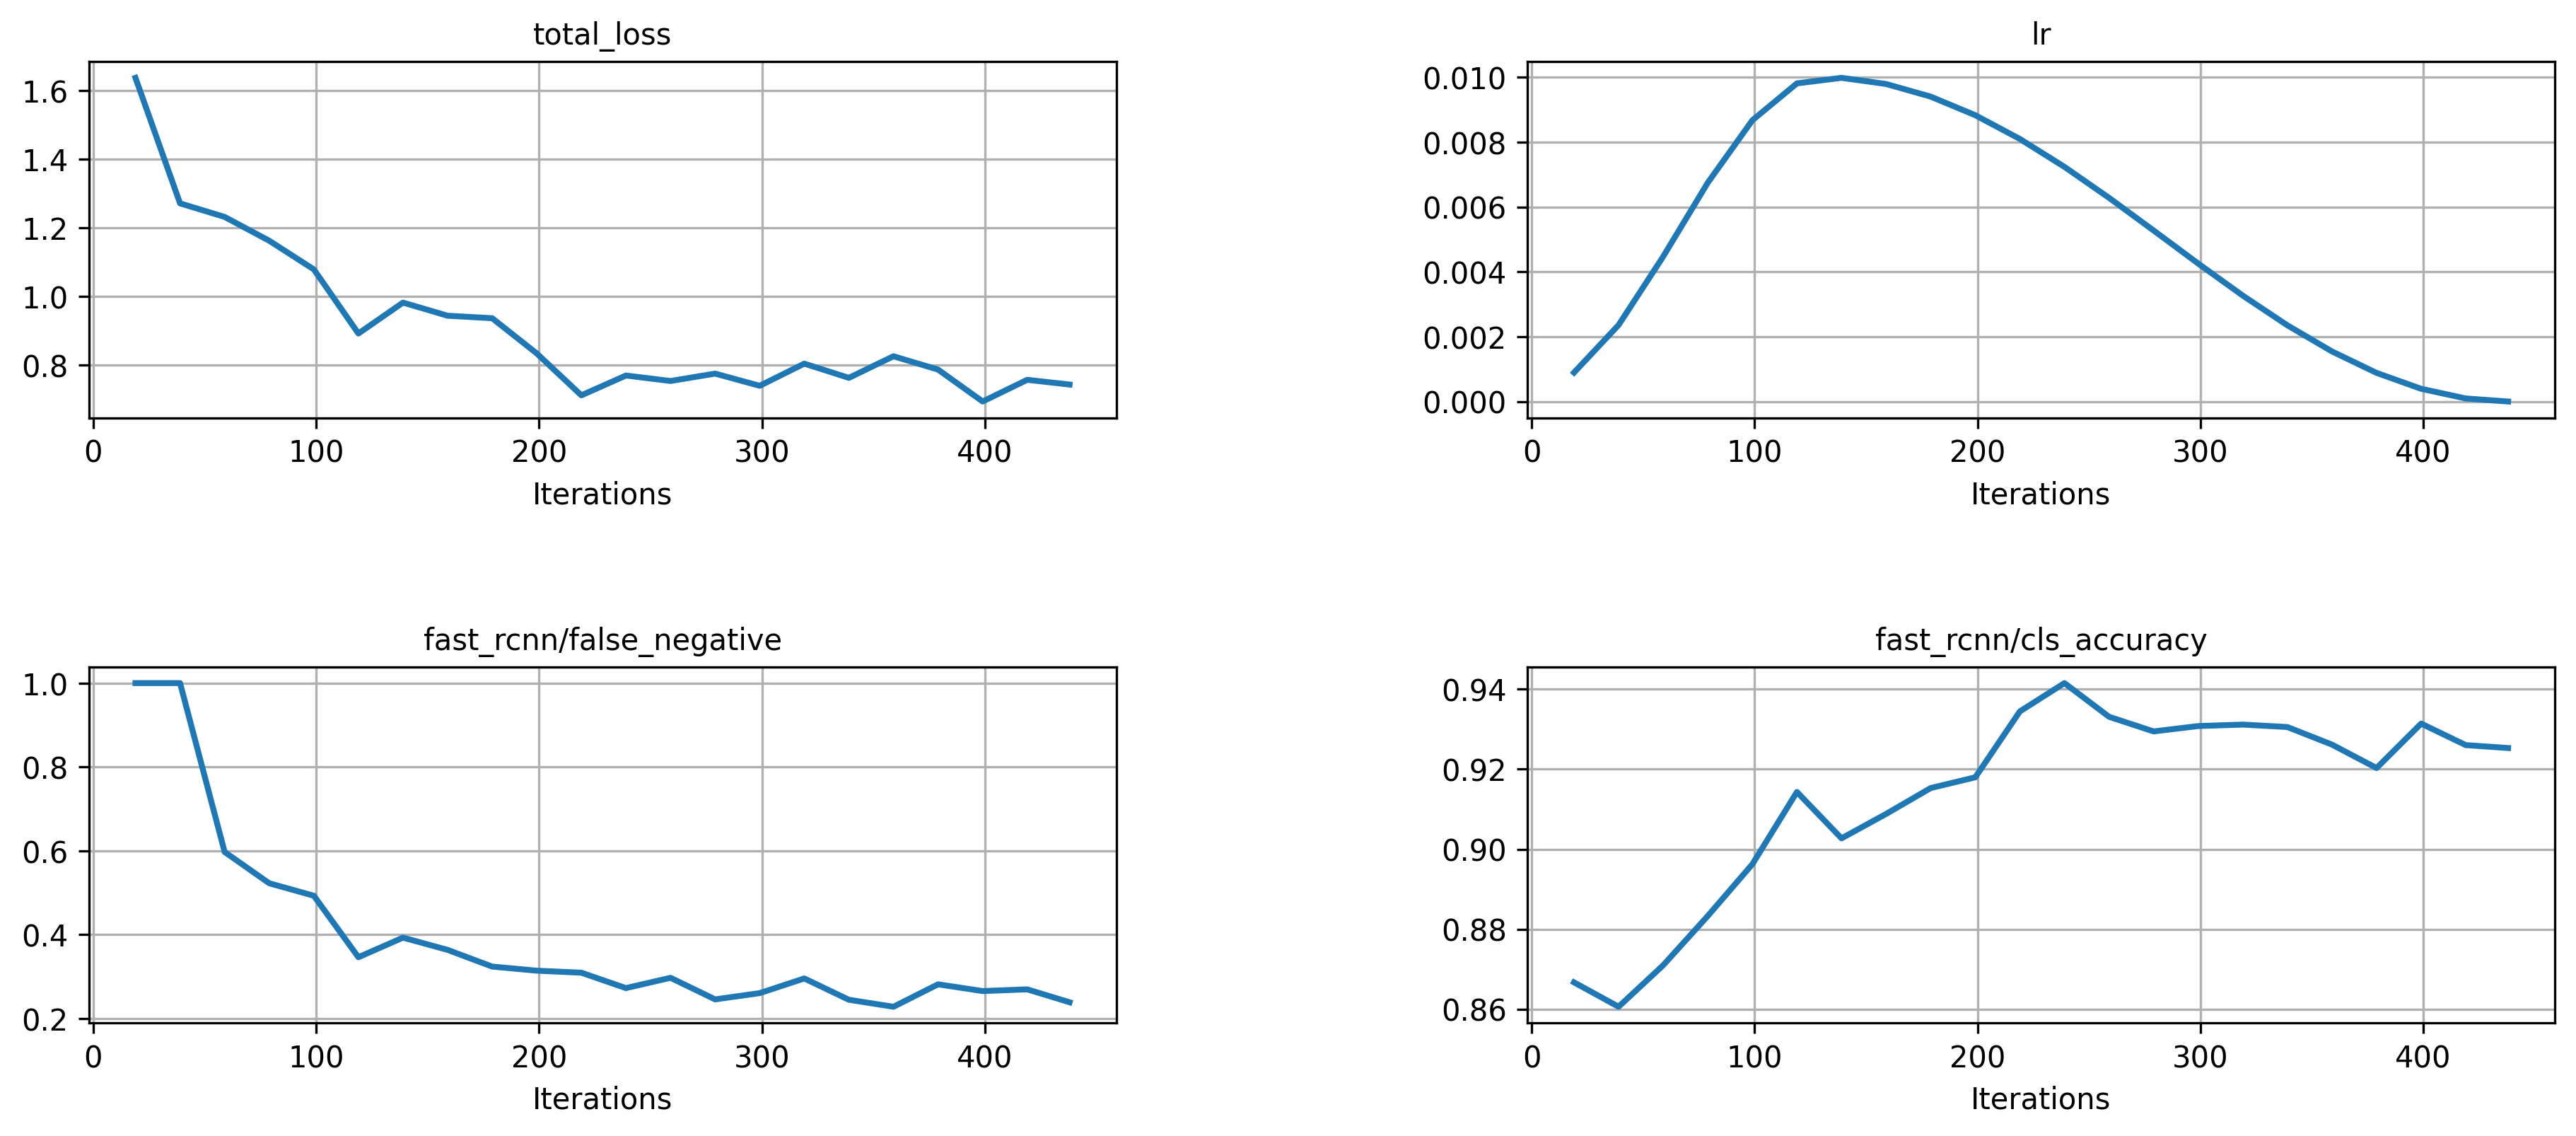

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
keys = ["total_loss", "lr", "mask_rcnn/accuracy", "loss_mask"] # adicionar keys válidas para mais plots.

fig = plt.figure(figsize=(15,6), dpi=300)
fig.subplots_adjust(hspace=0.7, wspace=0.4)
row_index = 2
line_index = (len(keys)//row_index)+1 if len(keys)%row_index != 0 else len(keys)//row_index
plotcount = 1
for k in keys:
  _ax = fig.add_subplot(line_index, row_index, plotcount)
  _ax.set_yscale('linear')
  _ax.plot(mt["iteration"], mt[k], linewidth=2.0)
  _ax.set_xlabel('Iterations', fontsize=10)
  _ax.set_title(k, fontsize=10)
  plt.grid()
  plotcount +=1
plt.show()

In [ ]:
#-- Visualizar inferência AP como tabela --
from IPython.display import display
import pandas as pd
if APmetrics is not None:
  df = pd.DataFrame.from_dict(APmetrics, orient='index') # key como linhas
  #df = pd.DataFrame(APmetrics, index=[0,]) # key como colunas
  display(df)

,0
bbox/AP,24.176695
bbox/AP-Cones,NaN
bbox/AP-blue_cone,33.992951
bbox/AP-large_orange_cone,27.784366
bbox/AP-orange_cone,25.078032
bbox/AP-unknown_cone,0.683135
bbox/AP-yellow_cone,33.344991
bbox/AP50,47.809784
bbox/AP75,22.028456
bbox/APl,77.623762


# 11 Bloco para resumir um treino parado anteriormente [RESUMIR = True]




In [ ]:
from glob import glob
import time
import datetime
import pytz
if RESUMIR:
  pasta_para_resumir = PASTA_RESUMO
  if pasta_para_resumir == "":
    all_runs = glob(os.path.join(RUNS_PATH,"*/"))
    lrt = len(RUNS_PATH)
    last_date = None
    last_run = None
    last_time = None
    for _run in all_runs:
      _date, _time = _run[lrt:-1].split('2022')
      run_date = time.strptime(_date + '2022', "%d-%m-%Y")
      run_hour, run_min, run_sec = _time.strip('_').split('_')
      run_time = run_hour*60 + run_min*60 + run_sec
      if last_date is None:
        last_date = run_date
        last_run = _run
        last_time = run_time
      elif run_date > last_date:
        lastaadptação_date = run_date
        last_run = _run
        last_time = run_time
      elif run_date == last_date:
        if run_time > last_time:
          last_date = run_date
          last_run = _run
          last_time = run_time
      else:
        pass
    pasta_para_resumir = last_run
  else:
    pasta_para_resumir = os.path.join(RUNS_PATH, PASTA_RESUMO)

  print("Resumindo do diretorio:", pasta_para_resumir)
  models = glob(os.path.join(pasta_para_resumir, "*.pth"))
  selected_model = None
  aux = 0
  for m in models:
    numbers = ''.join([x for x in m if x.isdigit()])
    if int(numbers) > aux:
      selected_model = m
      aux = int(numbers)
  print("Resumindo do modelo:", selected_model)
  time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
  
  _msg = "Iniciando configurações de resumo: OK"
  print(_msg)

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
import matplotlib.pyplot as plt
import datetime
import pytz
import numpy as np
import cv2
import os
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultTrainer
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo

if RESUMIR:
  time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
  _msg = "Iniciando resumo de treino: OK (resumo iniciado em {dia}/{mes}/{ano} as {hora}:{minuto}:{segundo})".format(dia=time_now.day, mes=time_now.month, ano=time_now.year, hora=time_now.hour, minuto=time_now.minute, segundo=time_now.second)
  print(_msg)

  setup_logger()

  RUNS_PATH = pasta_para_resumir # definindo run path de resumo
  cfg = get_cfg()
  cfg.ONECYCLE = CfgNode({"LIMIT": 0.01, "MAX_MOMENTUM": 0.95, "MIN_MOMENTUM": 0.85, "THREE_PHASE": False})
  cfg.merge_from_file(os.path.join(RUNS_PATH,"mask_instance_R50.yml"))
  cfg.MODEL.WEIGHTS = selected_model
  register_coco_instances("instance_train", {}, os.path.join(BASE_PATH, "dataset/simple_street_segmentation/train/train.json"), os.path.join(BASE_PATH, "dataset/simple_street_segmentation/train"))
  register_coco_instances("instance_val", {}, os.path.join(BASE_PATH, "dataset/simple_street_segmentation/valid/valid.json"), os.path.join(BASE_PATH, "dataset/simple_street_segmentation/valid"))
  print("Executando: " + str(cfg.SOLVER.MAX_ITER) + " iterations.")
  trainer = DeepUFSCTrainer(cfg)

  if WANDB_LOGGER or NPT_LOGGER:
    exlogger_hook = ExternalLogger(npt=NPT_LOGGER, wndb=WANDB_LOGGER, resume=True)
    trainer.register_hooks([exlogger_hook])
  trainer.resume_or_load(resume=True) # True para resumir do checkpoint encontrado ou do melhor peso encontrado.
  trainer.train()
  time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))

  
  _msg = "Resumo de treino finalizado em {dia}/{mes}/{ano} as {hora}:{minuto}:{segundo})".format(dia=time_now.day, mes=time_now.month, ano=time_now.year, hora=time_now.hour, minuto=time_now.minute, segundo=time_now.second)
  print(_msg)

<img src="http://lapix.ufsc.br/wp-content/uploads/2022/10/rodape-lapix.png">

